# Identificação e Reconhecimento Facial

## Importação das Bibliotecas e Introdução

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import random
import torch
from sklearn.manifold import TSNE
from sklearn import preprocessing
from facenet_pytorch import InceptionResnetV1, MTCNN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# Definir a seed para reprodutibilidade
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)  # Se estiver usando GPU

sns.set_style("whitegrid", {'axes.grid' : False})

# Definir tamanho padrão das figuras (largura x altura em polegadas)
plt.rcParams["figure.figsize"] = (3, 3)

Vamos fazer um estudo de benchmarking entre os 3 classificadores (Eingenfaces, Fihserfaces e LBPH) e a FaceNet.
Para entender melhor os pontos positivos de cada um deles, foi utilizado o [dataset do LFW (Label Faces Wild)](http://vis-www.cs.umass.edu/lfw/#deepfunnel-anchor) de faces alinhadas. Diferentemente do dataset original, foi separado 19 celebridades das quais possuem, no mínimo, 40 imagens para treinamento.

In [33]:
# !git clone https://github.com/michelpf/dataset-lfw-filtered

Exemplos das celebridades disponíveis.

In [34]:
# Exibição das imagens
img1 = cv2.imread("dataset-lfw-filtered/Ariel_Sharon/Ariel_Sharon_0001.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

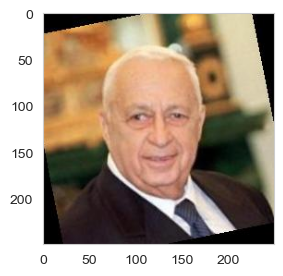

In [35]:
plt.imshow(img1)
plt.show()

## Identificação do ROI

### Identificação e segmentação de região de interesse com HaarCascade

In [36]:
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# def extrator_face_bgr(imagem):
    
#     imagem_gray = cv2.cvtColor(imagem,cv2.COLOR_BGR2GRAY)
#     faces = face_cascade.detectMultiScale(imagem_gray, 1.2, 5)
    
#     if faces is ():
#         return None
    
#     for (x,y,w,h) in faces:
#         roi = imagem[y:y+h, x:x+w]
    
#     return roi

### Identificação e segmentação de região de interesse com MTCNN (desempenho superior)

In [37]:
# Carregar o modelo MTCNN
mtcnn = MTCNN(keep_all=True)

def extrator_face_bgr(imagem):
    # Converter a imagem de BGR para RGB, pois o MTCNN espera essa codificação
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    
    # Detectar faces usando o MTCNN
    boxes, _ = mtcnn.detect(imagem_rgb)
    
    # Se nenhuma face for detectada, retorna None
    if boxes is None or len(boxes) == 0:
        return None
    
    # Selecionar a face com a maior área (considerada a mais próxima)
    max_area = 0
    best_box = None
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        area = width * height
        if area > max_area:
            max_area = area
            best_box = box
            
    # Ajustar a bounding box para ser quadrada
    x_min, y_min, x_max, y_max = best_box
    width = x_max - x_min
    height = y_max - y_min
    side_length = max(width, height)
    
    # Calcular o centro da bounding box original
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    
    # Definir a nova bounding box quadrada
    new_x_min = int(center_x - side_length / 2)
    new_x_max = int(center_x + side_length / 2)
    new_y_min = int(center_y - side_length / 2)
    new_y_max = int(center_y + side_length / 2)
    
    # Garantir que as coordenadas estejam dentro dos limites da imagem
    new_x_min = max(0, new_x_min)
    new_y_min = max(0, new_y_min)
    new_x_max = min(imagem.shape[1], new_x_max)
    new_y_max = min(imagem.shape[0], new_y_max)
    
    # Recortar a face (ROI) da imagem original
    roi = imagem[new_y_min:new_y_max, new_x_min:new_x_max]
    
    return roi

## Reconhecimento Facial

### Extração da Face nas imagens (executar apenas 1 vez, para organizar as imagens na pasta)

Adicionamos fotos de membros do nosso grupo: Paola e Felipe Fabossi

In [40]:
# # Dicionário para armazenar as estatísticas por pasta
# # A chave será o caminho da pasta e o valor um dicionário com contagem de 'sucesso' e 'erro'
# stats = {}

# # Percorre todos os arquivos .jpg dentro do diretório e subdiretórios
# for f in tqdm(glob.glob('dataset-lfw-filtered/**/*.jpg', recursive=True)):
#     imagem = cv2.imread(f)  # Carrega a imagem
    
#     # Tenta extrair a face da imagem
#     face = extrator_face_bgr(imagem)
    
#     # Obtém o diretório (pasta) da imagem, por exemplo: "dataset-lfw-filtered\person1"
#     pasta = os.path.dirname(f)
    
#     # Inicializa as contagens para essa pasta, se ainda não existir
#     if pasta not in stats:
#         stats[pasta] = {"sucesso": 0, "erro": 0}
    
#     if face is not None:
#         # Converte o espaço de cor (se necessário)
#         face = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
        
#         # Obtém o nome do arquivo
#         file_name = os.path.basename(f)
        
#         # Define o caminho de saída, adicionando o prefixo "face_"
#         output_path = os.path.join(pasta, "face_" + file_name)
        
#         # Salva a imagem processada
#         cv2.imwrite(output_path, face)
        
#         # Incrementa a contagem de sucesso para essa pasta
#         stats[pasta]["sucesso"] += 1
#     else:
#         # Incrementa a contagem de erro para essa pasta
#         stats[pasta]["erro"] += 1

In [41]:
# # Contagem total de sucessos e erros
# total_sucesso = sum(contagens["sucesso"] for contagens in stats.values())
# total_erro = sum(contagens["erro"] for contagens in stats.values())
# total_imagens = total_sucesso + total_erro

# print(f"\nTotal de Imagens: {total_imagens} | Erros: {total_erro} | Sucessos: {total_sucesso} ({total_sucesso / total_imagens * 100:.2f}%)")

In [42]:
# # Cria uma lista para armazenar os dados das pastas
# dados_pastas = []

# # Adiciona os dados de sucesso e erro de cada pasta
# for pasta, contagens in stats.items():
#     sucesso = contagens["sucesso"]
#     erro = contagens["erro"]
#     percentual = (sucesso / (sucesso + erro)) * 100 if (sucesso + erro) > 0 else 0  # Evita divisão por zero

#     dados_pastas.append({
#         "Pasta": os.path.basename(pasta),
#         "Sucessos": sucesso,
#         "Erros": erro,
#         "%": percentual
#     })

# # Cria um DataFrame com os dados das pastas
# df_pastas = pd.DataFrame(dados_pastas)

# # Formata a coluna "%" para exibir como string com 2 casas decimais
# df_pastas["%"] = df_pastas["%"].apply(lambda x: f"{x:.2f}") 

# df_pastas[df_pastas["%"].astype("float") < 100].sort_values(by="%", ascending=True)

### Preparação para o treinamento dos modelos

In [38]:
def padronizar_imagem(imagem):
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    imagem = cv2.resize(imagem, (200, 200), interpolation=cv2.INTER_LANCZOS4)
    imagem = imagem.astype('float32') / 255.0  # Normalizar para [0, 1]
    return imagem

In [39]:
def padronizar_imagem_facenet(imagem):
    imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    imagem = cv2.resize(imagem, (160, 160), interpolation=cv2.INTER_LANCZOS4)
    imagem = imagem.astype('float32') / 255.0  # Normalizar para [0, 1]
    imagem = torch.tensor(imagem).permute(2, 0, 1).unsqueeze(0)  # Converter para Tensor (1,3,160,160)
    return imagem

In [43]:
lista_sujeitos = []
lista_imagens = []
lista_imagens_facenet = []

for f in tqdm(glob.glob('dataset-lfw-filtered/**/face_*.jpg', recursive=True)):
  dir_name = os.path.dirname(f)  # Exemplo: "dataset-lfw-filtered\person1"
  lista_sujeitos.append(dir_name.split(os.path.sep)[1])
  
  imagem_raw = cv2.imread(f)

  imagem = padronizar_imagem(imagem_raw)
  lista_imagens.append(imagem)

  lista_imagens_facenet.append(imagem_raw)

100%|██████████| 1907/1907 [00:01<00:00, 1142.85it/s]


In [44]:
len(lista_sujeitos), len(lista_imagens), len(lista_imagens_facenet)

(1907, 1907, 1907)

### Separando dados de treinamento e teste

Utilizando o método ```train_test_split``` dividimos os dados em 4 listas, sendo:

* ```X_train```: imagens de treinamento
* ```X_teste```: imagens para teste
* ```y_train```: classes de treinamento
* ```y_test```: classes de teste

In [45]:
X_train, X_test, y_train, y_test = train_test_split(lista_imagens, lista_sujeitos, test_size=0.3, random_state=42)

In [46]:
len(X_train),len(X_test), len(y_train), len(y_test)

(1334, 573, 1334, 573)

In [47]:
X_train[0]

array([[0.07843138, 0.08235294, 0.08627451, ..., 0.16862746, 0.16078432,
        0.15686275],
       [0.07843138, 0.08235294, 0.08627451, ..., 0.17254902, 0.16470589,
        0.16078432],
       [0.07843138, 0.07843138, 0.08235294, ..., 0.18039216, 0.16862746,
        0.16470589],
       ...,
       [0.12156863, 0.11764706, 0.11372549, ..., 0.24705882, 0.24705882,
        0.24705882],
       [0.12156863, 0.11764706, 0.10980392, ..., 0.24313726, 0.24313726,
        0.24313726],
       [0.12156863, 0.11764706, 0.10980392, ..., 0.23921569, 0.23921569,
        0.23921569]], dtype=float32)

In [48]:
sujeitos = list(set(lista_sujeitos))

Neste caso, o label "George_W_Bush", assoicado ao índice 0, deverá ser transformado (_encode_) para um valor numérico.

In [49]:
y_train[0]

'Tony_Blair'

In [50]:
le = preprocessing.LabelEncoder()
le.fit(sujeitos)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

O valor numérico, para o valor acima de string do label, será:

In [51]:
y_train[0]

19

### Modelo EigenFaces - Treinamento e Validação

In [52]:
modelo_eingenfaces = cv2.face.EigenFaceRecognizer_create()
modelo_eingenfaces.train(X_train, y_train)

Preparação dos testes de validação, que é a execução do modelo contro as imagens reservadas para teste.

In [53]:
y_pred_eingenfaces = []

for item in tqdm(X_test):
    y_pred_eingenfaces.append(modelo_eingenfaces.predict(item)[0])
    
acuracia_eingenfaces = accuracy_score(y_test, y_pred_eingenfaces)
acuracia_eingenfaces

100%|██████████| 573/573 [01:36<00:00,  5.96it/s]


0.4013961605584642

### Modelo FischerFaces - Treinamento e Validação

In [54]:
modelo_lda = cv2.face.FisherFaceRecognizer_create()
modelo_lda.train(X_train, y_train)

In [55]:
y_pred_lda = []

for item in tqdm(X_test):
    y_pred_lda.append(modelo_lda.predict(item)[0])
    
acuracia_lda = accuracy_score(y_test, y_pred_lda)
acuracia_lda

100%|██████████| 573/573 [00:00<00:00, 1397.30it/s]


0.525305410122164

### Modelo LBPH - Treinamento e Validação

In [56]:
modelo_lbph = cv2.face.LBPHFaceRecognizer_create()
modelo_lbph.train(X_train, y_train)

In [57]:
y_pred_lbph = []

for item in tqdm(X_test):
    y_pred_lbph.append(modelo_lbph.predict(item)[0])
    
acuracia_lbph = accuracy_score(y_test, y_pred_lbph)
acuracia_lbph

100%|██████████| 573/573 [00:35<00:00, 16.12it/s]


0.7835951134380453

Daddo que as imagens não seguem um padrão de captura, ou seja, estão com poses diferentes uma das outras e levando em consideração que em cada sujeito havia uma pose com baixa luminosidade, pudemos verificar que o classificador Eingenfaces não conseguiu obter precisão de 40%. Enquanto a abordagem por LDA, do classificador Fisherfaces, obteve 52%. Por outro lado, o classificador LBPH foi o mais robusto dentre os 3, alcançando 78% de precisão, aproximadamente.

O teste a seguir é para verificarmos que além da identificação do sujeito, temos o valor da distância de similaridade. Com ela podemos também deduzir um limite máximo para determinar se a identificação é indeterminada.

Predição LBPH: ['Ariel_Sharon'] | Distancia: 0.0
Predição LDA: ['Ariel_Sharon'] | Distancia: 0.0
Predição Eigenfaces: ['Ariel_Sharon'] | Distancia: 0.0


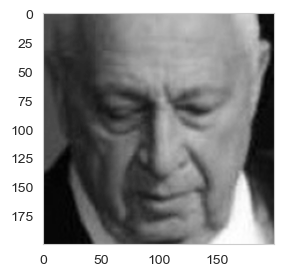

In [58]:
imagem = cv2.imread("dataset-lfw-filtered/Ariel_Sharon/face_Ariel_Sharon_0029.jpg")
roi_padronizado = padronizar_imagem(imagem)

plt.imshow(roi_padronizado, cmap="gray")

predicao_lbph = modelo_lbph.predict(roi_padronizado)
predicao_lda = modelo_lda.predict(roi_padronizado)
predicao_eingenfaces = modelo_eingenfaces.predict(roi_padronizado)

print(f"Predição LBPH: {le.inverse_transform([predicao_lbph[0]])} | Distancia: {predicao_lbph[1]}")
print(f"Predição LDA: {le.inverse_transform([predicao_lda[0]])} | Distancia: {predicao_lda[1]}")
print(f"Predição Eigenfaces: {le.inverse_transform([predicao_eingenfaces[0]])} | Distancia: {predicao_eingenfaces[1]}")

### Transfer Learning com FaceNet

In [59]:
sujeitos = list(set(lista_sujeitos))

In [60]:
X_train, X_test, y_train, y_test = train_test_split(lista_imagens_facenet, lista_sujeitos, test_size=0.3, random_state=42)

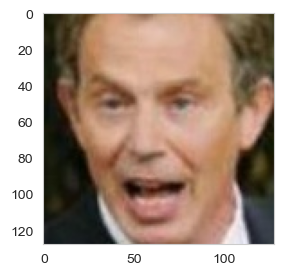

In [61]:
plt.imshow(X_train[0])

In [62]:
le = preprocessing.LabelEncoder()
le.fit(sujeitos)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [63]:
# Inicializa o modelo FaceNet (InceptionResnetV1 pré-treinado no VGGFace2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
facenet_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

def extrair_embedding(imagem):
    """Extrai o embedding da imagem usando FaceNet"""
    try:
        imagem_tensor = padronizar_imagem_facenet(imagem).to(device)  # Move para GPU
        with torch.no_grad():
            embedding = facenet_model(imagem_tensor)  # Extrai embedding
        return embedding.cpu().numpy().flatten()  # Move para CPU antes de converter para NumPy
    except Exception as e:
        print(f"Erro ao processar imagem: {e}")
        return None


cuda


In [64]:
X_train_embeddings = np.array([extrair_embedding(img) for img in X_train])
X_test_embeddings = np.array([extrair_embedding(img) for img in X_test])

In [65]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Criar e treinar o classificador SVM
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train_embeddings, y_train)

# Fazer previsões
y_pred = clf.predict(X_test_embeddings)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy}')

# Exibir o relatório de classificação
class_report = classification_report(y_test, y_pred, target_names=sujeitos)
print(class_report)

Acurácia do modelo: 0.987783595113438
                           precision    recall  f1-score   support

           Lleyton_Hewitt       1.00      1.00      1.00        21
    Arnold_Schwarzenegger       1.00      1.00      1.00         8
                    Paola       0.97      0.99      0.98        74
        Gerhard_Schroeder       1.00      1.00      1.00        34
              Hugo_Chavez       1.00      1.00      1.00         8
          Serena_Williams       0.97      0.99      0.98       160
Luiz_Inacio_Lula_da_Silva       1.00      1.00      1.00        30
               Laura_Bush       1.00      1.00      1.00         9
        Junichiro_Koizumi       1.00      0.92      0.96        26
               Tony_Blair       1.00      1.00      1.00        16
           Vladimir_Putin       1.00      1.00      1.00        18
             Ariel_Sharon       1.00      1.00      1.00        15
            George_W_Bush       1.00      1.00      1.00        14
        Jennifer_Capria

## Conclusão

Com base em nossos testes e nosso conjunto de ferramentas utilizadas, a melhor forma encontrada de identificar o ROI facial é com o MTCNN, e o modelo de melhor acurácia para reconhecer e classificar as faces é a FaceNet, através de Transfer Learning.

## Análise de Componentes Principais com tSNE e Visualizações

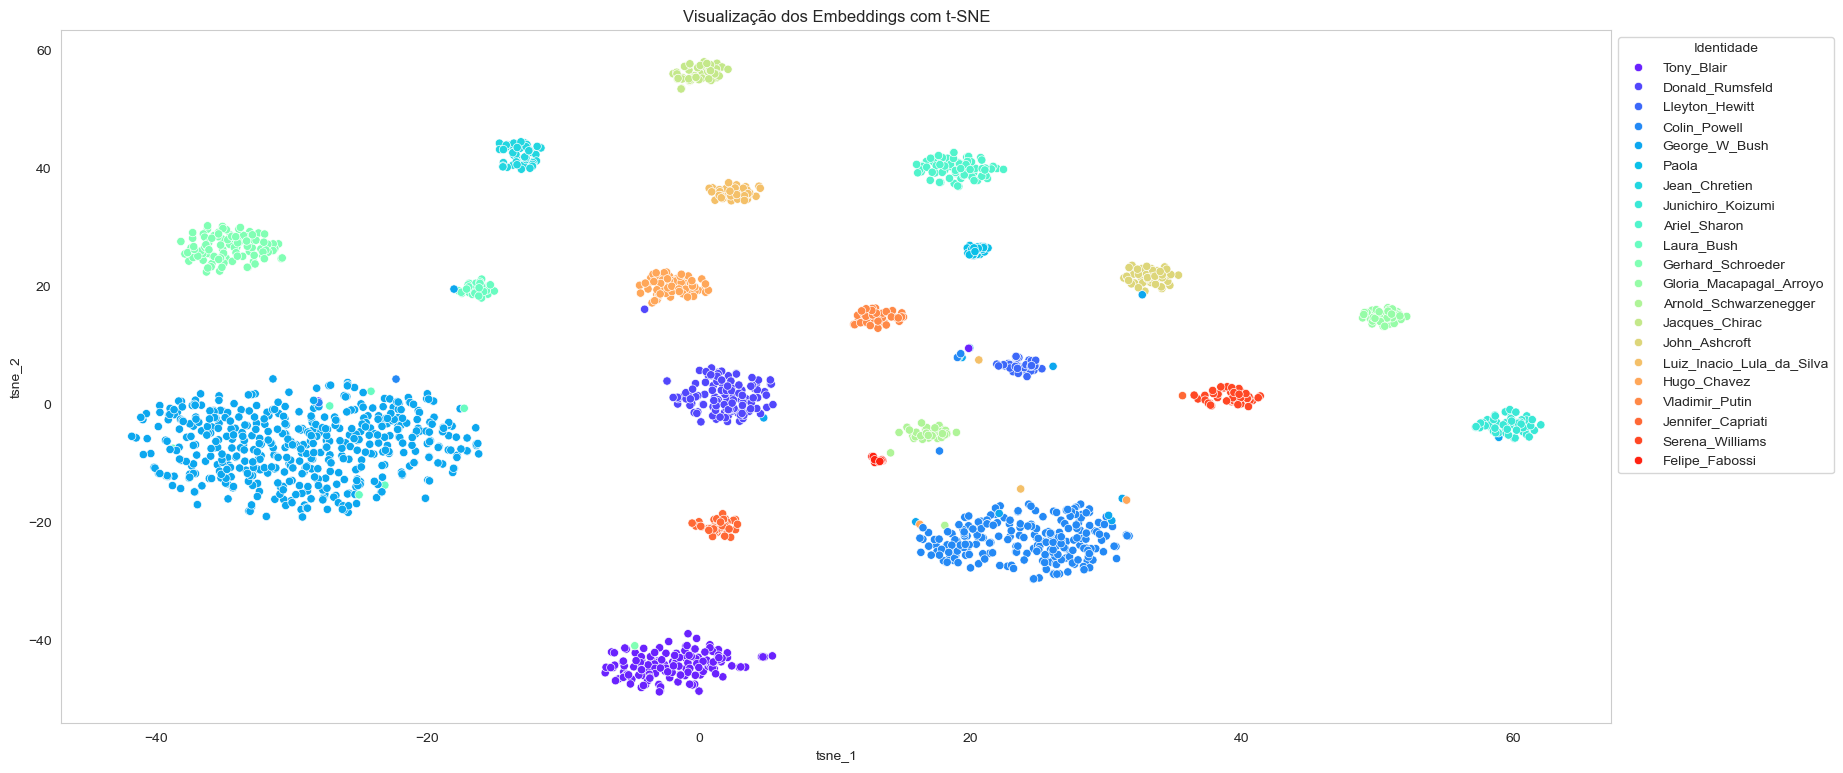

In [66]:
# Juntar os embeddings e os rótulos
X_embeddings = np.concatenate([X_train_embeddings, X_test_embeddings])
y_labels = np.concatenate([y_train, y_test])

# Aplicar t-SNE para reduzir a dimensionalidade para 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_embeddings)

# Se 'label_encoder' foi usado antes, podemos converter os números de volta para os nomes originais
y_labels_str = le.inverse_transform(y_labels)

# Atualizar o DataFrame com rótulos corrigidos
df_tsne = pd.DataFrame({"tsne_1": X_embedded[:, 0], "tsne_2": X_embedded[:, 1], "label": y_labels_str})

# Agora o Seaborn interpretará os rótulos corretamente
plt.figure(figsize=(20, 9))
sns.scatterplot(x="tsne_1", y="tsne_2", hue="label", palette="rainbow", data=df_tsne, alpha=1)
plt.title("Visualização dos Embeddings com t-SNE")
plt.legend(title="Identidade", bbox_to_anchor=(1, 1))  # Coloca a legenda fora do gráfico
plt.show()

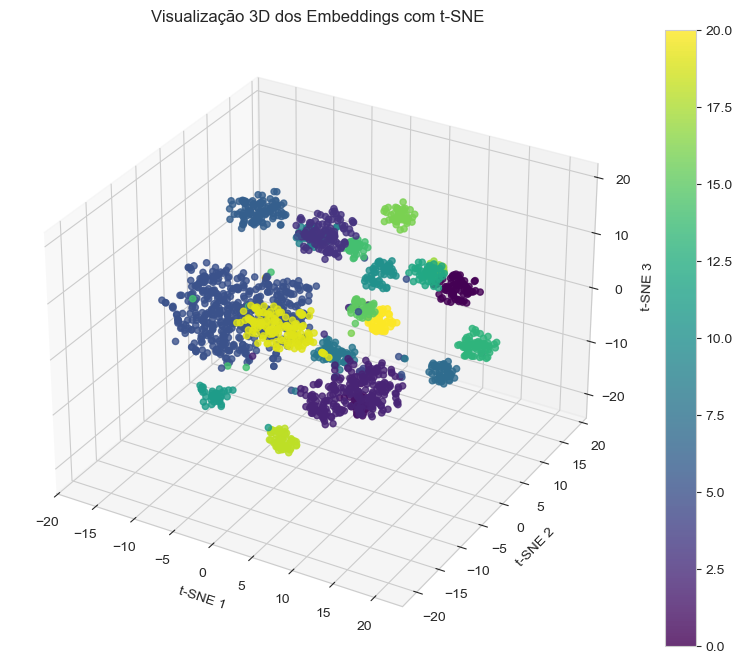

In [67]:
from mpl_toolkits.mplot3d import Axes3D

# Aplicar t-SNE para reduzir a 3D
tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42)
X_embedded_3d = tsne_3d.fit_transform(X_embeddings)

# Criar o gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotando os pontos
scatter = ax.scatter(X_embedded_3d[:, 0], X_embedded_3d[:, 1], X_embedded_3d[:, 2], 
                      c=y_labels, cmap="viridis", alpha=0.8)

# Configuração do gráfico
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
plt.title("Visualização 3D dos Embeddings com t-SNE")
plt.colorbar(scatter)
plt.show()

In [68]:
import plotly.express as px
import pandas as pd

# Criar DataFrame com as coordenadas e rótulos
df_tsne_3d = pd.DataFrame(X_embedded_3d, columns=['t-SNE 1', 't-SNE 2', 't-SNE 3'])
df_tsne_3d['label'] = y_labels_str  # Adicionar os rótulos

# Criar o gráfico interativo
fig = px.scatter_3d(df_tsne_3d, x='t-SNE 1', y='t-SNE 2', z='t-SNE 3', color='label', 
                    color_continuous_scale='viridis', title="Visualização 3D dos Embeddings com t-SNE")

# Mostrar o gráfico
fig.show()

In [ ]:
# Variáveis utilizadas no código
%whos

Variable                    Type                    Data/Info
-------------------------------------------------------------
Axes3D                      type                    <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>
InceptionResnetV1           type                    <class 'facenet_pytorch.m<...>et_v1.InceptionResnetV1'>
MTCNN                       type                    <class 'facenet_pytorch.models.mtcnn.MTCNN'>
SVC                         ABCMeta                 <class 'sklearn.svm._classes.SVC'>
TSNE                        type                    <class 'sklearn.manifold._t_sne.TSNE'>
X_embedded                  ndarray                 1907x2: 3814 elems, type `float32`, 15256 bytes
X_embedded_3d               ndarray                 1907x3: 5721 elems, type `float32`, 22884 bytes
X_embeddings                ndarray                 1907x512: 976384 elems, type `float32`, 3905536 bytes (3.724609375 Mb)
X_test                      list                    n=573
X_test_embeddin